# Set up

In [1]:
import torch
import torch.nn as nn
import numpy as np
import xarray as xr
from torch.utils.data import TensorDataset, DataLoader
from train import apply_inverse_zca_whitening_4d_torch
from unet import UNet  
from utils import *
from tqdm import tqdm
from sklearn.metrics import r2_score

# ============================================================================
# SETUP AND INITIALIZATION
# ============================================================================
setup_random_seeds(42)
device = get_device()
base_path = "gs://leap-persistent/YueWang/SSH/data"
storage_opts = {"token": "cloud", "asynchronous": False}

# Load data
train = open_zarr(f"{base_path}/train_80_sst.zarr", storage_opts)
test = open_zarr(f"{base_path}/test_80_sst.zarr", storage_opts)
zca = open_zarr(f"{base_path}/zca_80.zarr", storage_opts)

# Load ZCA transformation parameters
Vt = torch.from_numpy(zca.ubm_Vt.values).float().to(device)
scale = torch.from_numpy(zca.ubm_scale.values).float().to(device)
mean = torch.from_numpy(zca.ubm_mean.values).float().to(device)

# ============================================================================
# DATA PREPARATION
# ============================================================================
stoch_sample_draw = 100

# Prepare training data for normalization statistics (SSH+SST)
x_train_ssh = torch.from_numpy(train.ssh.values).float().unsqueeze(1).to(device)
x_train_sst = torch.from_numpy(train.sst.values).float().unsqueeze(1).to(device)
x_train = torch.cat([x_train_ssh, x_train_sst], dim=1)
x_train_normalized, min_vals_sst, max_vals_sst = min_max_normalize(x_train)

# Prepare test data (SSH+SST) 
x_test_ssh_original = torch.from_numpy(test.ssh.values).float().unsqueeze(1).to(device)
x_test_sst_original = torch.from_numpy(test.sst.values).float().unsqueeze(1).to(device)
x_test_original = torch.cat([x_test_ssh_original, x_test_sst_original], dim=1)

# Normalize test data for model input
x_test_normalized, _, _ = min_max_normalize(x_test_original, min_vals_sst, max_vals_sst)

# Prepare test targets
y_test_physical = torch.from_numpy(test.ubm.values).float().unsqueeze(1).to(device)
y_test_zca = torch.from_numpy(test.zca_ubm.values).float().unsqueeze(1).to(device)
y_test = torch.cat([y_test_physical, y_test_zca], dim=1)

# Create test dataset and loader
test_dataset_sst = TensorDataset(x_test_normalized, y_test)
test_loader_sst = DataLoader(test_dataset_sst, batch_size=32*4, shuffle=False)

# ============================================================================
# MODEL LOADING
# ============================================================================
model_sst_ssh = UNet(in_channels=2, out_channels=2, initial_features=32, depth=4)
model_sst_ssh.to(device)
checkpoint = torch.load('/home/jovyan/GRL_ssh/checkpoints/sst_ssh.pth', map_location=device)
model_sst_ssh.load_state_dict(checkpoint['model_state_dict'])

# ============================================================================
# MODEL EVALUATION
# ============================================================================
model_sst_ssh.eval()
results_sst_ssh = {
    'ssh': [], 'sst': [], 'ubm_true': [], 'bm_true': [],
    'ubm_pred_mu': [], 'bm_pred_mu': [],
    'ubm_pred_ensembles': [], 'bm_pred_ensembles': []
}
sample_indices = []

with torch.no_grad():
    for i, (batch_x, batch_y) in enumerate(tqdm(test_loader_sst)):
        
        batch_start = i * test_loader_sst.batch_size
        batch_end = min(batch_start + test_loader_sst.batch_size, len(test_dataset_sst))
        current_batch_indices = list(range(batch_start, batch_end))
        sample_indices.extend(current_batch_indices)
        
        batch_x = batch_x.to(device)
        batch_y_physical = batch_y[:, 0:1, ...].to(device)
        outputs = model_sst_ssh(batch_x)
        
        ssh_batch_original = x_test_ssh_original[current_batch_indices]
        sst_batch_original = x_test_sst_original[current_batch_indices]
        
        ubm_true = batch_y_physical
        bm_true = ssh_batch_original - ubm_true
        
        # Predicted mean in physical space
        mu_zca = outputs[:, 0, ...]
        log_sigma_zca = outputs[:, 1, ...]
        mu_zca_expanded = mu_zca.unsqueeze(1)
        ubm_pred_mu = apply_inverse_zca_whitening_4d_torch(mu_zca_expanded, Vt, scale, mean)
        
        bm_pred_mu = ssh_batch_original - ubm_pred_mu
        
        # Generate ensemble samples
        zca_samples = generate_gaussian_samples(mu_zca, log_sigma_zca, n_samples=stoch_sample_draw)
        B, n_samples, H, W = zca_samples.shape
        zca_samples_flat = zca_samples.reshape(B * n_samples, 1, H, W)
        ubm_samples_flat = apply_inverse_zca_whitening_4d_torch(zca_samples_flat, Vt, scale, mean)
        ubm_samples = ubm_samples_flat.reshape(B, n_samples, 1, H, W)
        
        # Use original SSH for ensemble BM calculation
        ssh_expanded = ssh_batch_original.unsqueeze(1).expand(-1, n_samples, -1, -1, -1)
        bm_samples = ssh_expanded - ubm_samples
        
        # Store results 
        results_sst_ssh['ssh'].append(ssh_batch_original.cpu().numpy())
        results_sst_ssh['sst'].append(sst_batch_original.cpu().numpy())
        results_sst_ssh['ubm_true'].append(ubm_true.cpu().numpy())
        results_sst_ssh['bm_true'].append(bm_true.cpu().numpy())
        results_sst_ssh['ubm_pred_mu'].append(ubm_pred_mu.cpu().numpy())
        results_sst_ssh['bm_pred_mu'].append(bm_pred_mu.cpu().numpy())
        results_sst_ssh['ubm_pred_ensembles'].append(ubm_samples.cpu().numpy())
        results_sst_ssh['bm_pred_ensembles'].append(bm_samples.cpu().numpy())

# Concatenate results
for key in results_sst_ssh:
    results_sst_ssh[key] = np.concatenate(results_sst_ssh[key], axis=0)
print("Model 1 evaluation complete!")

# ============================================================================
# CREATE XARRAY DATASETS
# ============================================================================
models_results = [
    ('sst_ssh', results_sst_ssh, True, True),
]

eval_datasets = {}
for model_name, results, has_ensembles, has_sst in models_results:
    print(f"Creating dataset for {model_name}...")
    eval_dataset = create_evaluation_dataset_samples(results, model_name, has_ensembles, has_sst, stochastic_samples=stoch_sample_draw)
    eval_datasets[model_name] = eval_dataset

# Assign coordinates
for k in eval_datasets.keys(): 
    eval_datasets[k] = eval_datasets[k].assign_coords(i=eval_datasets[k].i * 1.5, j=eval_datasets[k].j * 1.5)

# ============================================================================
# HELPER FUNCTIONS FOR ANALYSIS
# ============================================================================
def flatten_clean(da, clean_idx):
    return da.isel(sample=clean_idx).stack(pixels=("i", "j")).values

def find_extreme_samples(model_pred, truth, clean_idx, model_name="Selected Model"):
    """Find sample indices with maximum, median, and minimum R² values"""
    r2_vals = []
    
    for t, p in zip(flatten_clean(truth, clean_idx), flatten_clean(model_pred, clean_idx)):
        m = np.isfinite(t) & np.isfinite(p)
        if m.sum() < 2:
            r2_vals.append(np.nan)
        else:
            r2_vals.append(r2_score(t[m], p[m]))
    
    r2_vals = np.array(r2_vals)
    non_nan_indices = np.where(~np.isnan(r2_vals))[0]
    valid_r2 = r2_vals[non_nan_indices]
    
    max_local_idx = np.argmax(valid_r2)
    min_local_idx = np.argmin(valid_r2)
    sorted_indices = np.argsort(valid_r2)
    median_local_idx = sorted_indices[len(sorted_indices) // 2]
    
    max_sample_idx = clean_idx[non_nan_indices[max_local_idx]]
    min_sample_idx = clean_idx[non_nan_indices[min_local_idx]]
    median_sample_idx = clean_idx[non_nan_indices[median_local_idx]]
    
    return {
        "max": {"sample_idx": int(max_sample_idx), "r2": float(valid_r2[max_local_idx])},
        "median": {"sample_idx": int(median_sample_idx), "r2": float(valid_r2[median_local_idx])},
        "min": {"sample_idx": int(min_sample_idx), "r2": float(valid_r2[min_local_idx])}
    }

# ============================================================================
# EXTREME SAMPLE ANALYSIS
# ============================================================================
clean_mask = ~test.ubm.isnull().any(dim=("i", "j")).values
clean_idx = np.where(clean_mask)[0]

extreme_samples = {}
extreme_samples['sst_ssh'] = find_extreme_samples(
    eval_datasets['sst_ssh'].ubm_pred_mean, 
    test.ubm, 
    clean_idx, 
    model_name="ZCA+SST"
)

# ============================================================================
# FINAL DATASET SELECTION
# ============================================================================
model_name = 'sst_ssh'
ds = eval_datasets[model_name].sel(sample=clean_idx)

print("Evaluation pipeline complete!")

Using device: cpu


/srv/conda/envs/notebook/lib/python3.12/site-packages/zarr/storage/_fsspec.py:256: UserWarning: fs (<gcsfs.core.GCSFileSystem object at 0x7a03de28da30>) was not created with `asynchronous=True`, this may lead to surprising behavior
  return cls(fs=fs, path=path, read_only=read_only, allowed_exceptions=allowed_exceptions)
/srv/conda/envs/notebook/lib/python3.12/site-packages/zarr/storage/_fsspec.py:256: UserWarning: fs (<gcsfs.core.GCSFileSystem object at 0x7a03de28da30>) was not created with `asynchronous=True`, this may lead to surprising behavior
  return cls(fs=fs, path=path, read_only=read_only, allowed_exceptions=allowed_exceptions)
/srv/conda/envs/notebook/lib/python3.12/site-packages/zarr/storage/_fsspec.py:256: UserWarning: fs (<gcsfs.core.GCSFileSystem object at 0x7a03de28da30>) was not created with `asynchronous=True`, this may lead to surprising behavior
  return cls(fs=fs, path=path, read_only=read_only, allowed_exceptions=allowed_exceptions)
/tmp/ipykernel_53/3941255774.py

Model 1 evaluation complete!
Creating dataset for sst_ssh...
Adding ensemble data with shape: (3645, 100, 1, 80, 80)
Evaluation pipeline complete!


# Plot

Working with snapshot 3041
Prediction shape: (100, 80, 80)
True value shape: (80, 80)
Quantiles shape: (11, 80, 80)
50.0% CI: Expected 0.50, Observed 0.437, Valid pixels: 6400
80.0% CI: Expected 0.80, Observed 0.753, Valid pixels: 6400
90.0% CI: Expected 0.90, Observed 0.870, Valid pixels: 6400
95.0% CI: Expected 0.95, Observed 0.931, Valid pixels: 6400
100.0% CI: Expected 1.00, Observed 0.983, Valid pixels: 6400
Computing pooled calibration across all 2907 snapshots
Total pixels to analyze: 18604800
Computing quantiles across stochastic samples...
Quantiles shape: (11, 2907, 80, 80)

Analyzing 50.0% confidence interval...
  Expected: 0.500, Observed: 0.364, Error: 0.136, Valid pixels: 18,604,800

Analyzing 80.0% confidence interval...
  Expected: 0.800, Observed: 0.597, Error: 0.203, Valid pixels: 18,604,800

Analyzing 90.0% confidence interval...
  Expected: 0.900, Observed: 0.693, Error: 0.207, Valid pixels: 18,604,800

Analyzing 95.0% confidence interval...
  Expected: 0.950, Obser

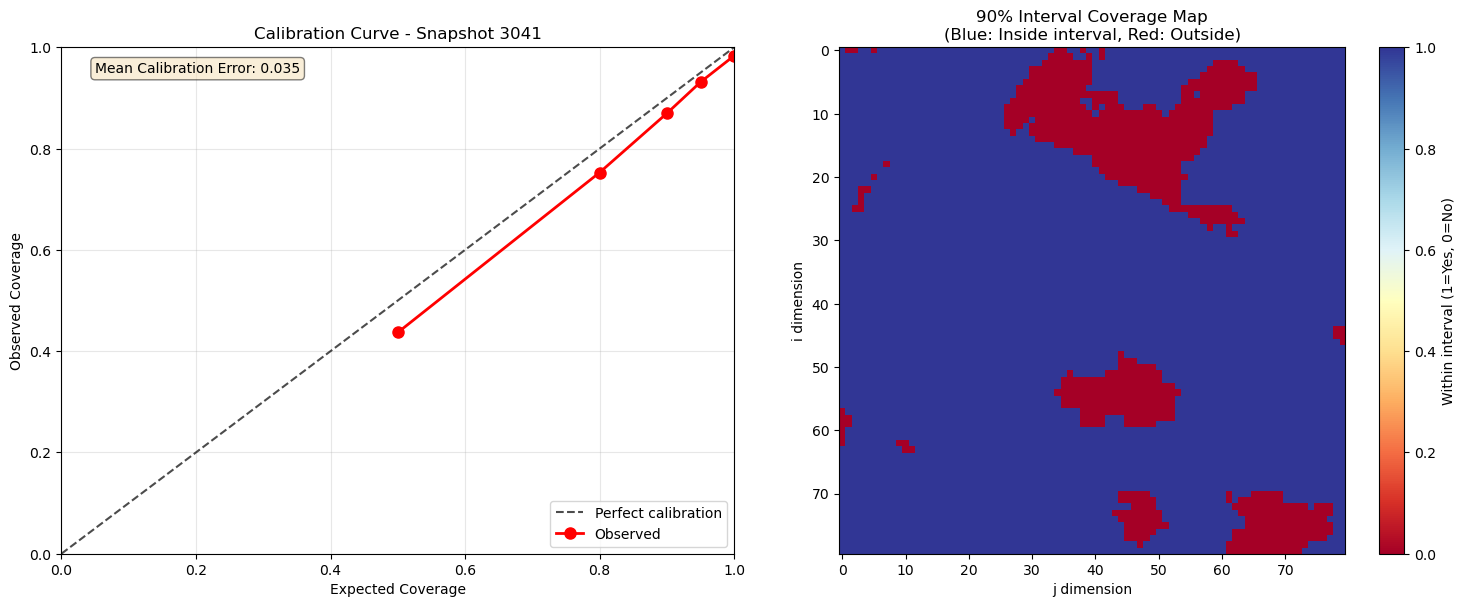

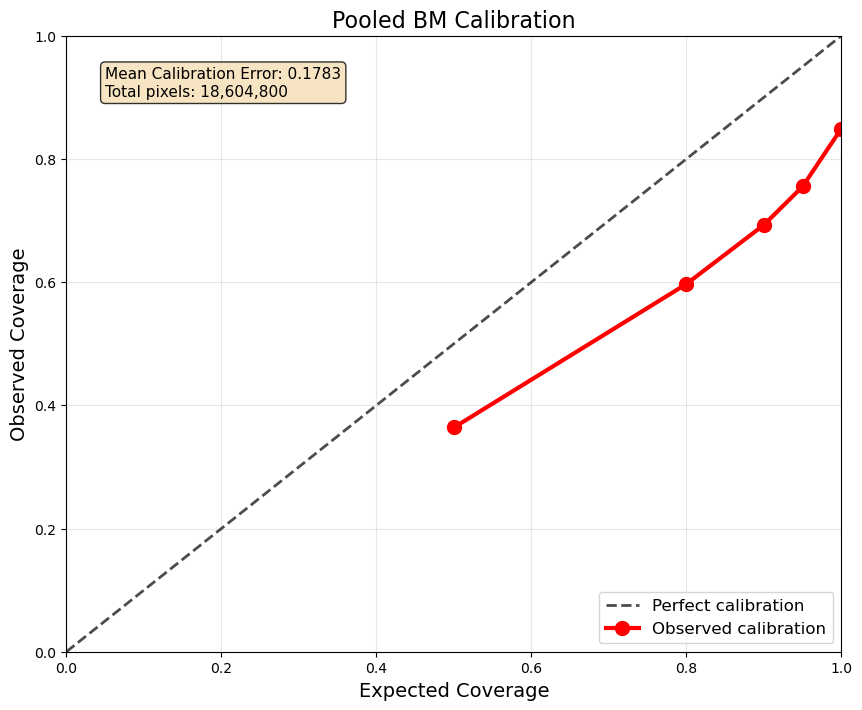


Calibration analysis complete!


In [2]:
import numpy as np
import matplotlib.pyplot as plt

# ============================================================================
# CALIBRATION COMPUTATION FUNCTIONS
# ============================================================================

def compute_single_snapshot_calibration(predictions_da, true_values_da, snapshot_idx=0):
    """
    Compute calibration statistics for a single SSH snapshot.
    
    Parameters:
    -----------
    predictions_da : xarray.DataArray
        Predictions with dimensions (sample, i, j, stochastic_sample)
    true_values_da : xarray.DataArray  
        True values with dimensions (sample, i, j)
    snapshot_idx : int
        Which snapshot to analyze (index in the 'sample' dimension)
        
    Returns:
    --------
    calibration_results : dict
        Contains coverage statistics and quantile information
    """
    
    # Select single snapshot
    single_pred = predictions_da.sel(sample=snapshot_idx)  # Shape: (i=80, j=80, stochastic_sample=500)
    single_true = true_values_da.sel(sample=snapshot_idx)  # Shape: (i=80, j=80)
    
    print(f"Working with snapshot {snapshot_idx}")
    print(f"Prediction shape: {single_pred.shape}")
    print(f"True value shape: {single_true.shape}")
    
    # Define quantile levels for different confidence intervals
    confidence_levels = [0.5, 0.8, 0.9, 0.95, 1.0]
    quantile_pairs = {
        0.5: [0.25, 0.75],    # 50% CI: 25th to 75th percentile
        0.8: [0.1, 0.9],      # 80% CI: 10th to 90th percentile  
        0.9: [0.05, 0.95],    # 90% CI: 5th to 95th percentile
        0.95: [0.025, 0.975],  # 95% CI: 2.5th to 97.5th percentile
        1.0: [0.0, 1.0]
    }
    
    # Compute quantiles across stochastic samples for each spatial location
    quantiles_da = single_pred.quantile(
        q=[0.0, 0.025, 0.05, 0.1, 0.25, 0.5, 0.75, 0.9, 0.95, 0.975, 1.0], 
        dim='stochastic_sample'
    )
    
    print(f"Quantiles shape: {quantiles_da.shape}")  # Should be (quantile=9, i=80, j=80)
    
    # Calculate coverage for each confidence level
    coverage_results = {}
    
    for conf_level, (lower_q, upper_q) in quantile_pairs.items():
        # Get lower and upper bounds for this confidence level
        lower_bound = quantiles_da.sel(quantile=lower_q)
        upper_bound = quantiles_da.sel(quantile=upper_q)
        
        # Check which pixels have true value within predicted interval
        within_interval = (single_true >= lower_bound) & (single_true <= upper_bound)
        
        # Calculate coverage (fraction of pixels where truth falls within interval)
        # Handle potential NaN values
        valid_pixels = ~(np.isnan(single_true) | np.isnan(lower_bound) | np.isnan(upper_bound))
        
        if valid_pixels.sum() > 0:
            coverage = within_interval.where(valid_pixels).sum() / valid_pixels.sum()
        else:
            coverage = np.nan
            
        coverage_results[conf_level] = {
            'expected_coverage': conf_level,
            'observed_coverage': float(coverage),
            'n_valid_pixels': int(valid_pixels.sum()),
            'within_interval_map': within_interval.where(valid_pixels)
        }
        
        print(f"{conf_level*100}% CI: Expected {conf_level:.2f}, Observed {coverage:.3f}, "
              f"Valid pixels: {int(valid_pixels.sum())}")
    
    return {
        'coverage_results': coverage_results,
        'quantiles': quantiles_da,
        'true_values': single_true,
        'predictions': single_pred,
        'snapshot_idx': snapshot_idx
    }


def compute_pooled_calibration(predictions_da, true_values_da, snapshot_idx=None):
    """
    Compute calibration statistics using pixel pooling across all snapshots.
    Treats every pixel from every snapshot as an independent calibration test.
    
    Parameters:
    -----------
    predictions_da : xarray.DataArray
        Predictions with dimensions (sample, i, j, stochastic_sample)
    true_values_da : xarray.DataArray  
        True values with dimensions (sample, i, j)
        
    Returns:
    --------
    calibration_results : dict
        Contains pooled coverage statistics
    """

    if snapshot_idx is None:
        print(f"Computing pooled calibration across all {predictions_da.sizes['sample']} snapshots")
        print(f"Total pixels to analyze: {predictions_da.sizes['sample'] * predictions_da.sizes['i'] * predictions_da.sizes['j']}")
    else: 
        # Select single snapshot
        predictions_da = predictions_da.sel(sample=snapshot_idx)  # Shape: (i=80, j=80, stochastic_sample=500)
        true_values_da = true_values_da.sel(sample=snapshot_idx)  # Shape: (i=80, j=80)
        
        print(f"Working with snapshot {snapshot_idx}")
        print(f"Prediction shape: {predictions_da.shape}")
        print(f"True value shape: {predictions_da.shape}")
    
    # Define confidence intervals
    confidence_levels = [0.5, 0.8, 0.9, 0.95, 1.0]
    quantile_pairs = {
        0.5: [0.25, 0.75],
        0.8: [0.1, 0.9], 
        0.9: [0.05, 0.95],
        0.95: [0.025, 0.975],
        1.0: [0.0, 1.0]
    }
    
    # Compute quantiles for all snapshots at once
    print("Computing quantiles across stochastic samples...")
    quantiles_da = predictions_da.quantile(
        q=[0.0, 0.025, 0.05, 0.1, 0.25, 0.5, 0.75, 0.9, 0.95, 0.975, 1.0],
        dim='stochastic_sample'
    )
    # Shape: (quantile=9, sample=128, i=80, j=80)
    
    print(f"Quantiles shape: {quantiles_da.shape}")
    
    # Calculate coverage by pooling all pixels from all snapshots
    coverage_results = {}
    
    for conf_level, (lower_q, upper_q) in quantile_pairs.items():
        print(f"\nAnalyzing {conf_level*100}% confidence interval...")
        
        # Get bounds for this confidence level (all snapshots, all pixels)
        lower_bound = quantiles_da.sel(quantile=lower_q)  # Shape: (sample=128, i=80, j=80)
        upper_bound = quantiles_da.sel(quantile=upper_q)  # Shape: (sample=128, i=80, j=80)
        
        # Check which pixels have true value within predicted interval
        within_interval = (true_values_da >= lower_bound) & (true_values_da <= upper_bound)
        
        # Identify valid pixels (no NaNs)
        valid_pixels = ~(np.isnan(true_values_da) | np.isnan(lower_bound) | np.isnan(upper_bound))
        
        # Calculate pooled coverage across ALL pixels from ALL snapshots
        if valid_pixels.sum() > 0:
            # This pools across all dimensions: sample, i, j
            total_within = within_interval.where(valid_pixels).sum()
            total_valid = valid_pixels.sum()
            coverage = total_within / total_valid
        else:
            coverage = np.nan
            total_valid = 0
            
        coverage_results[conf_level] = {
            'expected_coverage': conf_level,
            'observed_coverage': float(coverage),
            'n_valid_pixels': int(total_valid),
            'calibration_error': abs(float(coverage) - conf_level)
        }
        
        print(f"  Expected: {conf_level:.3f}, Observed: {coverage:.3f}, "
              f"Error: {abs(float(coverage) - conf_level):.3f}, "
              f"Valid pixels: {int(total_valid):,}")
    
    # Calculate overall calibration error
    errors = [res['calibration_error'] for res in coverage_results.values()]
    mean_calibration_error = np.mean(errors)
    
    print(f"\nOverall mean calibration error: {mean_calibration_error:.4f}")
    
    return {
        'coverage_results': coverage_results,
        'mean_calibration_error': mean_calibration_error,
        'total_pixels_analyzed': sum(res['n_valid_pixels'] for res in coverage_results.values()) // len(coverage_results)
    }


# ============================================================================
# VISUALIZATION FUNCTIONS
# ============================================================================

def plot_single_snapshot_calibration(calibration_results):
    """
    Plot calibration results for a single snapshot.
    """
    coverage_res = calibration_results['coverage_results']
    
    # Extract expected vs observed coverage
    expected = [res['expected_coverage'] for res in coverage_res.values()]
    observed = [res['observed_coverage'] for res in coverage_res.values()]
    
    fig, (ax1, ax2) = plt.subplots(1, 2, figsize=(15, 6))
    
    # Plot 1: Calibration curve
    ax1.plot([0, 1], [0, 1], 'k--', alpha=0.7, label='Perfect calibration')
    ax1.plot(expected, observed, 'ro-', linewidth=2, markersize=8, label='Observed')
    
    ax1.set_xlabel('Expected Coverage')
    ax1.set_ylabel('Observed Coverage') 
    ax1.set_title(f'Calibration Curve - Snapshot {calibration_results["snapshot_idx"]}')
    ax1.legend()
    ax1.grid(True, alpha=0.3)
    ax1.set_xlim(0, 1)
    ax1.set_ylim(0, 1)
    
    # Add calibration error text
    cal_error = np.mean(np.abs(np.array(expected) - np.array(observed)))
    ax1.text(0.05, 0.95, f'Mean Calibration Error: {cal_error:.3f}', 
             transform=ax1.transAxes, fontsize=10,
             bbox=dict(boxstyle='round', facecolor='wheat', alpha=0.5))
    
    # Plot 2: Spatial pattern of calibration (example with 90% interval)
    if 0.9 in coverage_res:
        within_map = coverage_res[0.9]['within_interval_map']
        im = ax2.imshow(within_map, cmap='RdYlBu', vmin=0, vmax=1)
        ax2.set_title('90% Interval Coverage Map\n(Blue: Inside interval, Red: Outside)')
        ax2.set_xlabel('j dimension')
        ax2.set_ylabel('i dimension')
        plt.colorbar(im, ax=ax2, label='Within interval (1=Yes, 0=No)')
    
    plt.tight_layout()
    plt.show()


def plot_pooled_calibration(calibration_results, title="Pooled SSH Calibration"):
    """
    Plot calibration curve for pooled results.
    """
    coverage_res = calibration_results['coverage_results']
    
    # Extract expected vs observed coverage
    expected = [res['expected_coverage'] for res in coverage_res.values()]
    observed = [res['observed_coverage'] for res in coverage_res.values()]
    errors = [res['calibration_error'] for res in coverage_res.values()]
    
    # Main calibration plot
    plt.plot([0, 1], [0, 1], 'k--', alpha=0.7, linewidth=2, label='Perfect calibration')
    plt.plot(expected, observed, 'ro-', linewidth=3, markersize=10, label='Observed calibration')
    
    plt.xlabel('Expected Coverage', fontsize=14)
    plt.ylabel('Observed Coverage', fontsize=14) 
    plt.title(title, fontsize=16)
    plt.legend(fontsize=12)
    plt.grid(True, alpha=0.3)
    plt.xlim(0, 1)
    plt.ylim(0, 1)
    
    # Add statistics text box
    mean_error = calibration_results['mean_calibration_error']
    n_pixels = calibration_results['total_pixels_analyzed']
    
    stats_text = f'Mean Calibration Error: {mean_error:.4f}\n'
    stats_text += f'Total pixels: {n_pixels:,}'
    
    plt.text(0.05, 0.95, stats_text, transform=plt.gca().transAxes, fontsize=11,
             bbox=dict(boxstyle='round', facecolor='wheat', alpha=0.8),
             verticalalignment='top')


# ============================================================================
# MAIN EXECUTION
# ============================================================================

# Compute calibration for single snapshot
single_snapshot = compute_single_snapshot_calibration(ds.bm_pred_samples, ds.bm_truth, 3041)

# Compute pooled calibration across all snapshots
all_snapshots = compute_pooled_calibration(ds.bm_pred_samples, ds.bm_truth)

# Visualize results
plot_single_snapshot_calibration(single_snapshot)

plt.figure(figsize=(10, 8))
plot_pooled_calibration(all_snapshots, title="Pooled BM Calibration")
plt.show()

print("\nCalibration analysis complete!")

In [4]:
# Analysis by PSD Intersection Bins (Log-spaced)
import warnings
import numpy as np
import matplotlib.pyplot as plt
import matplotlib.ticker as ticker
import xarray as xr
import xrft
from scipy.interpolate import interp1d
from tqdm import tqdm

# Suppress warnings
warnings.filterwarnings('ignore')


def isotropic_spectra(data):
    """Calculate the isotropic power spectrum of input data."""
    iso_psd = xrft.isotropic_power_spectrum(
        data, 
        dim=['i', 'j'], 
        detrend='constant', 
        window=True,
        nfactor=2
    )
    return iso_psd

def calculate_psd_km(field, dx=1.5):
    """Calculate PSD with spatial coordinates in km."""
    i_km = np.arange(field.shape[0]) * dx
    j_km = np.arange(field.shape[1]) * dx
    da = xr.DataArray(
        field,
        dims=['i', 'j'],
        coords={'i': i_km, 'j': j_km},
        name='field'
    )
    return isotropic_spectra(da)


def find_psd_intersection(bm_psd, ubm_psd, wavenumbers):
    """Find the first intersection point (smallest wavenumber) between BM and UBM PSDs"""
    try:
        # Find where UBM crosses above BM (or vice versa)
        diff = ubm_psd - bm_psd
        
        # Look for sign changes
        sign_changes = np.where(np.diff(np.sign(diff)))[0]
        
        if len(sign_changes) == 0:
            return None  # No intersection found
        
        # Return the wavenumber of the first intersection (smallest wavenumber)
        first_intersection_idx = sign_changes[0]
        
        # Linear interpolation to get more precise intersection point
        k1, k2 = wavenumbers[first_intersection_idx], wavenumbers[first_intersection_idx + 1]
        d1, d2 = diff[first_intersection_idx], diff[first_intersection_idx + 1]
        
        # Linear interpolation: find where diff crosses zero
        intersection_k = k1 - d1 * (k2 - k1) / (d2 - d1)
        
        return intersection_k
        
    except Exception as e:
        return None

def create_log_bins(k_min=1/120, k_max=1/2, n_bins=3):
    """Create equally spaced log bins across the wavenumber range"""
    log_min = np.log10(k_min)
    log_max = np.log10(k_max)
    
    # Create bin edges in log space
    log_edges = np.linspace(log_min, log_max, n_bins + 1)
    bin_edges = 10**log_edges
    
    return bin_edges

def custom_bins(): 
    return np.array([1/120, 1/40, 1/10, 1/1])

def bin_samples_by_intersection_logspace(eval_dataset, test_data, clean_idx_subset):
    """Bin samples based on BM-UBM PSD intersection wavenumbers using log-spaced bins"""
    
    # Create 4 equally spaced log bins
    #bin_edges = create_log_bins()
    bin_edges = custom_bins()
    n_bins = len(bin_edges) - 1
    
    # Initialize bins
    bins = {f'bin_{i}': [] for i in range(n_bins)}
    no_intersection_samples = []
    intersection_wavenumbers = []

    print("Bin edges (spatial scale in km):")
    for i in range(n_bins):
        km_low = 1/bin_edges[i+1]  # Note: reversed order since 1/k
        km_high = 1/bin_edges[i]
        print(f"Bin {i+1}: [{km_low:.1f}, {km_high:.1f}) km")
    
    # print("Bin edges (wavenumber):")
    # for i in range(n_bins):
    #     print(f"Bin {i+1}: [{bin_edges[i]:.4f}, {bin_edges[i+1]:.4f})")
    
    for sample_idx in tqdm(clean_idx_subset): #!! these kind of for loops are very slow.
        try:
            # Get true BM and UBM for this sample
            bm_true = eval_dataset.bm_truth.isel(sample=sample_idx).values
            ubm_true = eval_dataset.ubm_truth.isel(sample=sample_idx).values
            
            # Skip samples with NaNs
            if np.any(np.isnan(bm_true)) or np.any(np.isnan(ubm_true)):
                continue
                
            # Calculate PSDs
            psd_bm = calculate_psd_km(bm_true)
            #psd_bm = isotropic_spectra(bm_true)
            psd_ubm = calculate_psd_km(ubm_true)
            #psd_ubm = isotropic_spectra(ubm_true)
            
            wavenumbers = psd_bm[list(psd_bm.coords.keys())[0]].values
            
            # Find intersection
            intersection_k = find_psd_intersection(psd_bm.values, psd_ubm.values, wavenumbers)
            
            # Bin the sample
            if intersection_k is None:
                no_intersection_samples.append(sample_idx)
            else:
                intersection_wavenumbers.append(intersection_k)
                
                # Find which bin this intersection falls into
                bin_idx = np.digitize(intersection_k, bin_edges) - 1
                
                # Make sure it's within valid range
                if 0 <= bin_idx < n_bins:
                    bins[f'bin_{bin_idx}'].append(sample_idx)
                else:
                    no_intersection_samples.append(sample_idx)
                
        except Exception as e:
            continue
    
    return bins, no_intersection_samples, intersection_wavenumbers, bin_edges


In [5]:
# Bin samples by intersection wavenumbers
bins, no_intersection, intersection_ks, bin_edges = bin_samples_by_intersection_logspace(
    eval_datasets['sst_ssh'], test, clean_idx)

Bin edges (spatial scale in km):
Bin 1: [40.0, 120.0) km
Bin 2: [10.0, 40.0) km
Bin 3: [1.0, 10.0) km


100%|██████████| 2907/2907 [01:14<00:00, 39.22it/s]


In [7]:
for i in bins.keys():
    print(i, len(bins[i]))

bin_0 134
bin_1 2445
bin_2 275


In [8]:
bin0 = compute_pooled_calibration(ds.bm_pred_samples.sel(sample=bins['bin_0']), ds.bm_truth.sel(sample=bins['bin_0']))

Computing pooled calibration across all 134 snapshots
Total pixels to analyze: 857600
Computing quantiles across stochastic samples...
Quantiles shape: (11, 134, 80, 80)

Analyzing 50.0% confidence interval...
  Expected: 0.500, Observed: 0.267, Error: 0.233, Valid pixels: 857,600

Analyzing 80.0% confidence interval...
  Expected: 0.800, Observed: 0.469, Error: 0.331, Valid pixels: 857,600

Analyzing 90.0% confidence interval...
  Expected: 0.900, Observed: 0.566, Error: 0.334, Valid pixels: 857,600

Analyzing 95.0% confidence interval...
  Expected: 0.950, Observed: 0.635, Error: 0.315, Valid pixels: 857,600

Analyzing 100.0% confidence interval...
  Expected: 1.000, Observed: 0.750, Error: 0.250, Valid pixels: 857,600

Overall mean calibration error: 0.2927


In [10]:
bin1 = compute_pooled_calibration(ds.bm_pred_samples.sel(sample=bins['bin_1']), ds.bm_truth.sel(sample=bins['bin_1']))

Computing pooled calibration across all 2445 snapshots
Total pixels to analyze: 15648000
Computing quantiles across stochastic samples...
Quantiles shape: (11, 2445, 80, 80)

Analyzing 50.0% confidence interval...
  Expected: 0.500, Observed: 0.352, Error: 0.148, Valid pixels: 15,648,000

Analyzing 80.0% confidence interval...
  Expected: 0.800, Observed: 0.585, Error: 0.215, Valid pixels: 15,648,000

Analyzing 90.0% confidence interval...
  Expected: 0.900, Observed: 0.683, Error: 0.217, Valid pixels: 15,648,000

Analyzing 95.0% confidence interval...
  Expected: 0.950, Observed: 0.747, Error: 0.203, Valid pixels: 15,648,000

Analyzing 100.0% confidence interval...
  Expected: 1.000, Observed: 0.845, Error: 0.155, Valid pixels: 15,648,000

Overall mean calibration error: 0.1876


In [11]:
bin2 = compute_pooled_calibration(ds.bm_pred_samples.sel(sample=bins['bin_2']), ds.bm_truth.sel(sample=bins['bin_2']))

Computing pooled calibration across all 275 snapshots
Total pixels to analyze: 1760000
Computing quantiles across stochastic samples...
Quantiles shape: (11, 275, 80, 80)

Analyzing 50.0% confidence interval...
  Expected: 0.500, Observed: 0.544, Error: 0.044, Valid pixels: 1,760,000

Analyzing 80.0% confidence interval...
  Expected: 0.800, Observed: 0.796, Error: 0.004, Valid pixels: 1,760,000

Analyzing 90.0% confidence interval...
  Expected: 0.900, Observed: 0.871, Error: 0.029, Valid pixels: 1,760,000

Analyzing 95.0% confidence interval...
  Expected: 0.950, Observed: 0.911, Error: 0.039, Valid pixels: 1,760,000

Analyzing 100.0% confidence interval...
  Expected: 1.000, Observed: 0.958, Error: 0.042, Valid pixels: 1,760,000

Overall mean calibration error: 0.0316


Binning samples by PSD intersection...
Bin edges (spatial scale in km):
Bin 1: [40.0, 120.0) km
Bin 2: [10.0, 40.0) km
Bin 3: [1.0, 10.0) km


100%|██████████| 2907/2907 [01:13<00:00, 39.59it/s]



Bin sizes:
bin_0: 134 samples
bin_1: 2445 samples
bin_2: 275 samples

Computing calibration for Bin 0 (BM)...
Computing pooled calibration across all 134 snapshots
Total pixels to analyze: 857600
Computing quantiles across stochastic samples...
Quantiles shape: (11, 134, 80, 80)

Analyzing 50.0% confidence interval...
  Expected: 0.500, Observed: 0.267, Error: 0.233, Valid pixels: 857,600

Analyzing 80.0% confidence interval...
  Expected: 0.800, Observed: 0.469, Error: 0.331, Valid pixels: 857,600

Analyzing 90.0% confidence interval...
  Expected: 0.900, Observed: 0.566, Error: 0.334, Valid pixels: 857,600

Analyzing 95.0% confidence interval...
  Expected: 0.950, Observed: 0.635, Error: 0.315, Valid pixels: 857,600

Analyzing 100.0% confidence interval...
  Expected: 1.000, Observed: 0.750, Error: 0.250, Valid pixels: 857,600

Overall mean calibration error: 0.2927

Computing calibration for Bin 0 (UBM)...
Computing pooled calibration across all 134 snapshots
Total pixels to analyz

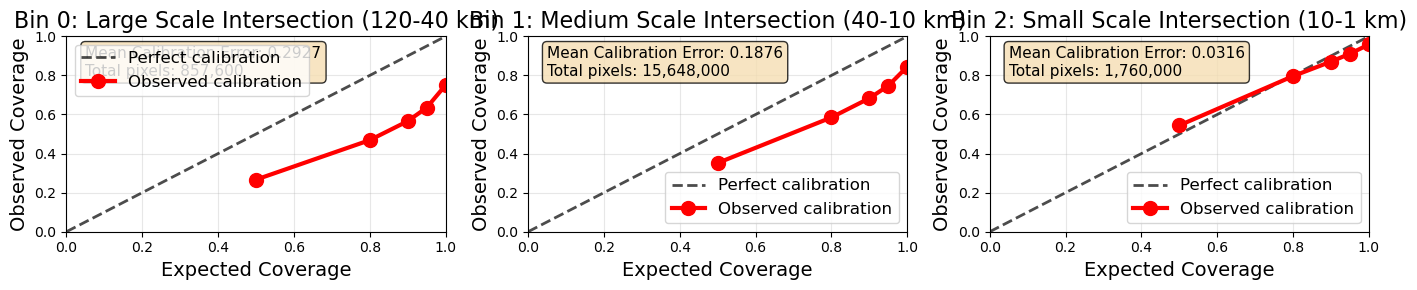


Stratified calibration analysis complete!


In [12]:
import warnings
import numpy as np
import matplotlib.pyplot as plt
import matplotlib.ticker as ticker
import xarray as xr
import xrft
from scipy.interpolate import interp1d
from tqdm import tqdm

# Suppress warnings
warnings.filterwarnings('ignore')

# ============================================================================
# PSD COMPUTATION FUNCTIONS
# ============================================================================

def isotropic_spectra(data):
    """Calculate the isotropic power spectrum of input data."""
    iso_psd = xrft.isotropic_power_spectrum(
        data, 
        dim=['i', 'j'], 
        detrend='constant', 
        window=True,
        nfactor=2
    )
    return iso_psd


def calculate_psd_km(field, dx=1.5):
    """Calculate PSD with spatial coordinates in km."""
    i_km = np.arange(field.shape[0]) * dx
    j_km = np.arange(field.shape[1]) * dx
    da = xr.DataArray(
        field,
        dims=['i', 'j'],
        coords={'i': i_km, 'j': j_km},
        name='field'
    )
    return isotropic_spectra(da)


# ============================================================================
# PSD INTERSECTION ANALYSIS
# ============================================================================

def find_psd_intersection(bm_psd, ubm_psd, wavenumbers):
    """Find the first intersection point (smallest wavenumber) between BM and UBM PSDs"""
    try:
        # Find where UBM crosses above BM (or vice versa)
        diff = ubm_psd - bm_psd
        
        # Look for sign changes
        sign_changes = np.where(np.diff(np.sign(diff)))[0]
        
        if len(sign_changes) == 0:
            return None  # No intersection found
        
        # Return the wavenumber of the first intersection (smallest wavenumber)
        first_intersection_idx = sign_changes[0]
        
        # Linear interpolation to get more precise intersection point
        k1, k2 = wavenumbers[first_intersection_idx], wavenumbers[first_intersection_idx + 1]
        d1, d2 = diff[first_intersection_idx], diff[first_intersection_idx + 1]
        
        # Linear interpolation: find where diff crosses zero
        intersection_k = k1 - d1 * (k2 - k1) / (d2 - d1)
        
        return intersection_k
        
    except Exception as e:
        return None


def create_log_bins(k_min=1/120, k_max=1/2, n_bins=3):
    """Create equally spaced log bins across the wavenumber range"""
    log_min = np.log10(k_min)
    log_max = np.log10(k_max)
    
    # Create bin edges in log space
    log_edges = np.linspace(log_min, log_max, n_bins + 1)
    bin_edges = 10**log_edges
    
    return bin_edges


def custom_bins(): 
    """Custom bin edges for wavenumber binning"""
    return np.array([1/120, 1/40, 1/10, 1/1])


def bin_samples_by_intersection_logspace(eval_dataset, test_data, clean_idx_subset):
    """Bin samples based on BM-UBM PSD intersection wavenumbers using log-spaced bins"""
    
    # Create bins
    bin_edges = custom_bins()
    n_bins = len(bin_edges) - 1
    
    # Initialize bins
    bins = {f'bin_{i}': [] for i in range(n_bins)}
    no_intersection_samples = []
    intersection_wavenumbers = []

    print("Bin edges (spatial scale in km):")
    for i in range(n_bins):
        km_low = 1/bin_edges[i+1]  # Note: reversed order since 1/k
        km_high = 1/bin_edges[i]
        print(f"Bin {i+1}: [{km_low:.1f}, {km_high:.1f}) km")
    
    for sample_idx in tqdm(clean_idx_subset):
        try:
            # Get true BM and UBM for this sample
            bm_true = eval_dataset.bm_truth.isel(sample=sample_idx).values
            ubm_true = eval_dataset.ubm_truth.isel(sample=sample_idx).values
            
            # Skip samples with NaNs
            if np.any(np.isnan(bm_true)) or np.any(np.isnan(ubm_true)):
                continue
                
            # Calculate PSDs
            psd_bm = calculate_psd_km(bm_true)
            psd_ubm = calculate_psd_km(ubm_true)
            
            wavenumbers = psd_bm[list(psd_bm.coords.keys())[0]].values
            
            # Find intersection
            intersection_k = find_psd_intersection(psd_bm.values, psd_ubm.values, wavenumbers)
            
            # Bin the sample
            if intersection_k is None:
                no_intersection_samples.append(sample_idx)
            else:
                intersection_wavenumbers.append(intersection_k)
                
                # Find which bin this intersection falls into
                bin_idx = np.digitize(intersection_k, bin_edges) - 1
                
                # Make sure it's within valid range
                if 0 <= bin_idx < n_bins:
                    bins[f'bin_{bin_idx}'].append(sample_idx)
                else:
                    no_intersection_samples.append(sample_idx)
                
        except Exception as e:
            continue
    
    return bins, no_intersection_samples, intersection_wavenumbers, bin_edges


# ============================================================================
# MAIN EXECUTION: BIN SAMPLES AND COMPUTE STRATIFIED CALIBRATION
# ============================================================================

# Bin samples by intersection wavenumbers
print("Binning samples by PSD intersection...")
bins, no_intersection, intersection_ks, bin_edges = bin_samples_by_intersection_logspace(
    eval_datasets['sst_ssh'], test, clean_idx
)

# Print bin sizes
print("\nBin sizes:")
for i in bins.keys():
    print(f"{i}: {len(bins[i])} samples")

# Compute calibration for BM predictions in each bin
print("\nComputing calibration for Bin 0 (BM)...")
bin0_bm = compute_pooled_calibration(
    ds.bm_pred_samples.sel(sample=bins['bin_0']), 
    ds.bm_truth.sel(sample=bins['bin_0'])
)

print("\nComputing calibration for Bin 0 (UBM)...")
bin0_ubm = compute_pooled_calibration(
    ds.ubm_pred_samples.sel(sample=bins['bin_0']), 
    ds.ubm_truth.sel(sample=bins['bin_0'])
)

print("\nComputing calibration for Bin 1 (BM)...")
bin1_bm = compute_pooled_calibration(
    ds.bm_pred_samples.sel(sample=bins['bin_1']), 
    ds.bm_truth.sel(sample=bins['bin_1'])
)

print("\nComputing calibration for Bin 2 (BM)...")
bin2_bm = compute_pooled_calibration(
    ds.bm_pred_samples.sel(sample=bins['bin_2']), 
    ds.bm_truth.sel(sample=bins['bin_2'])
)

print("\nComputing calibration for Bin 2 (UBM)...")
bin2_ubm = compute_pooled_calibration(
    ds.ubm_pred_samples.sel(sample=bins['bin_2']), 
    ds.ubm_truth.sel(sample=bins['bin_2'])
)

# ============================================================================
# VISUALIZATION: STRATIFIED CALIBRATION COMPARISON
# ============================================================================

print("\nCreating stratified calibration plots...")
plt.figure(figsize=(14, 3))

plt.subplot(131)
plot_pooled_calibration(bin0_bm, title="Bin 0: Large Scale Intersection (120-40 km)")

plt.subplot(132)
plot_pooled_calibration(bin1_bm, title="Bin 1: Medium Scale Intersection (40-10 km)")

plt.subplot(133)
plot_pooled_calibration(bin2_bm, title="Bin 2: Small Scale Intersection (10-1 km)")

plt.tight_layout()
plt.show()

print("\nStratified calibration analysis complete!")


SCALE-BASED CALIBRATION ANALYSIS

Processing scale: >40 km
Prediction dimensions: ('sample', 'stochastic_sample', 'i', 'j')
Prediction shape: (2907, 100, 80, 80)
Truth dimensions: ('sample', 'i', 'j')
Truth shape: (2907, 80, 80)
Filtering 2907 samples at scale {'mode': 'low', 'scale_km': 40, 'label': '>40 km'}...


100%|██████████| 2907/2907 [02:16<00:00, 21.26it/s]



Computing calibration for >40 km...
Computing pooled calibration across all 2907 snapshots
Total pixels to analyze: 18604800
Computing quantiles across stochastic samples...
Quantiles shape: (11, 2907, 80, 80)

Analyzing 50.0% confidence interval...
  Expected: 0.500, Observed: 0.370, Error: 0.130, Valid pixels: 18,604,800

Analyzing 80.0% confidence interval...
  Expected: 0.800, Observed: 0.598, Error: 0.202, Valid pixels: 18,604,800

Analyzing 90.0% confidence interval...
  Expected: 0.900, Observed: 0.689, Error: 0.211, Valid pixels: 18,604,800

Analyzing 95.0% confidence interval...
  Expected: 0.950, Observed: 0.749, Error: 0.201, Valid pixels: 18,604,800

Analyzing 100.0% confidence interval...
  Expected: 1.000, Observed: 0.841, Error: 0.159, Valid pixels: 18,604,800

Overall mean calibration error: 0.1808

Processing scale: 10-40 km
Prediction dimensions: ('sample', 'stochastic_sample', 'i', 'j')
Prediction shape: (2907, 100, 80, 80)
Truth dimensions: ('sample', 'i', 'j')
Tru

100%|██████████| 2907/2907 [02:58<00:00, 16.28it/s]



Computing calibration for 10-40 km...
Computing pooled calibration across all 2907 snapshots
Total pixels to analyze: 18604800
Computing quantiles across stochastic samples...
Quantiles shape: (11, 2907, 80, 80)

Analyzing 50.0% confidence interval...
  Expected: 0.500, Observed: 0.365, Error: 0.135, Valid pixels: 18,604,800

Analyzing 80.0% confidence interval...
  Expected: 0.800, Observed: 0.607, Error: 0.193, Valid pixels: 18,604,800

Analyzing 90.0% confidence interval...
  Expected: 0.900, Observed: 0.708, Error: 0.192, Valid pixels: 18,604,800

Analyzing 95.0% confidence interval...
  Expected: 0.950, Observed: 0.774, Error: 0.176, Valid pixels: 18,604,800

Analyzing 100.0% confidence interval...
  Expected: 1.000, Observed: 0.871, Error: 0.129, Valid pixels: 18,604,800

Overall mean calibration error: 0.1649

Processing scale: <10 km
Prediction dimensions: ('sample', 'stochastic_sample', 'i', 'j')
Prediction shape: (2907, 100, 80, 80)
Truth dimensions: ('sample', 'i', 'j')
Tru

100%|██████████| 2907/2907 [01:12<00:00, 40.01it/s]



Computing calibration for <10 km...
Computing pooled calibration across all 2907 snapshots
Total pixels to analyze: 18604800
Computing quantiles across stochastic samples...
Quantiles shape: (11, 2907, 80, 80)

Analyzing 50.0% confidence interval...
  Expected: 0.500, Observed: 0.465, Error: 0.035, Valid pixels: 18,604,800

Analyzing 80.0% confidence interval...
  Expected: 0.800, Observed: 0.742, Error: 0.058, Valid pixels: 18,604,800

Analyzing 90.0% confidence interval...
  Expected: 0.900, Observed: 0.838, Error: 0.062, Valid pixels: 18,604,800

Analyzing 95.0% confidence interval...
  Expected: 0.950, Observed: 0.892, Error: 0.058, Valid pixels: 18,604,800

Analyzing 100.0% confidence interval...
  Expected: 1.000, Observed: 0.953, Error: 0.047, Valid pixels: 18,604,800

Overall mean calibration error: 0.0520

Creating two-panel calibration comparison...


NameError: name 'bin0_bm' is not defined

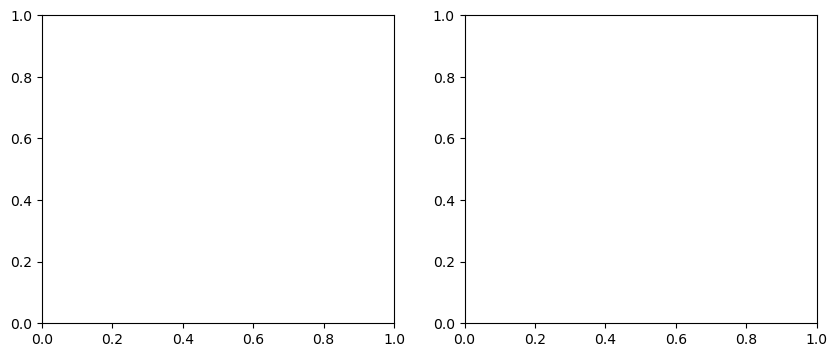

In [6]:
import matplotlib.pyplot as plt
import numpy as np
from scipy.ndimage import gaussian_filter
from tqdm import tqdm

# ============================================================================
# SCALE-BASED FILTERING FUNCTIONS
# ============================================================================

def extract_scale_component(field, scale_km, pixel_size=1.5, mode='high'):
    """
    Extract features at a specific spatial scale using Gaussian filtering.
    
    Parameters:
    -----------
    field : np.ndarray
        2D spatial field
    scale_km : float or tuple
        Spatial scale in kilometers
    pixel_size : float
        Grid spacing in kilometers
    mode : str
        'high' for high-pass (features < scale_km)
        'low' for low-pass (features >= scale_km)
        'band' for band-pass (requires scale_km to be a tuple)
        
    Returns:
    --------
    filtered_field : np.ndarray
        Filtered field
    """
    if mode == 'band':
        # Band-pass: features between scale_km[1] and scale_km[0]
        low_scale, high_scale = scale_km
        low_pass_low = extract_scale_component(field, low_scale, pixel_size, mode='low')
        low_pass_high = extract_scale_component(field, high_scale, pixel_size, mode='low')
        return low_pass_low - low_pass_high
    
    scale_pixels = scale_km / pixel_size
    sigma = scale_pixels / np.sqrt(12)
    
    low_pass = gaussian_filter(field, sigma=sigma)
    
    if mode == 'high':
        return field - low_pass  # High-pass: features < scale_km
    else:
        return low_pass  # Low-pass: features >= scale_km


def filter_dataset_by_scale(predictions_da, truth_da, scale_config, pixel_size=1.5):
    """
    Filter both predictions and ground truth at a specific spatial scale.
    
    Parameters:
    -----------
    predictions_da : xarray.DataArray
        Predictions - will auto-detect dimension order
    truth_da : xarray.DataArray
        Ground truth with shape (sample, i, j)
    scale_config : dict
        Configuration with 'mode' and 'scale_km'
    pixel_size : float
        Grid spacing in kilometers
        
    Returns:
    --------
    filtered_predictions : xarray.DataArray
        Filtered predictions
    filtered_truth : xarray.DataArray
        Filtered ground truth
    """
    
    # Get dimension names and shapes
    pred_dims = predictions_da.dims
    pred_shape = predictions_da.shape
    
    print(f"Prediction dimensions: {pred_dims}")
    print(f"Prediction shape: {pred_shape}")
    print(f"Truth dimensions: {truth_da.dims}")
    print(f"Truth shape: {truth_da.shape}")
    
    # Determine dimension order
    sample_dim = 'sample'
    stochastic_dim = 'stochastic_sample'
    
    # Get spatial dimension names (should be 'i' and 'j')
    spatial_dims = [d for d in pred_dims if d not in [sample_dim, stochastic_dim]]
    
    n_samples = len(predictions_da[sample_dim])
    n_ensembles = len(predictions_da[stochastic_dim])
    
    # Initialize arrays for filtered data
    filtered_pred = np.zeros_like(predictions_da.values)
    filtered_truth = np.zeros_like(truth_da.values)
    
    print(f"Filtering {n_samples} samples at scale {scale_config}...")
    
    for sample_idx in tqdm(range(n_samples)):
        # Filter ground truth
        truth_field = truth_da.isel({sample_dim: sample_idx}).values
        
        if not np.any(np.isnan(truth_field)):
            filtered_truth[sample_idx] = extract_scale_component(
                truth_field, 
                scale_config['scale_km'], 
                pixel_size, 
                scale_config['mode']
            )
        else:
            filtered_truth[sample_idx] = truth_field  # Keep NaNs
        
        # Filter all ensemble members
        for ens_idx in range(n_ensembles):
            pred_field = predictions_da.isel({sample_dim: sample_idx, stochastic_dim: ens_idx}).values
            
            if not np.any(np.isnan(pred_field)):
                filtered_field = extract_scale_component(
                    pred_field,
                    scale_config['scale_km'],
                    pixel_size,
                    scale_config['mode']
                )
                
                # Figure out correct indexing based on dimension order
                if pred_dims == (sample_dim, stochastic_dim, spatial_dims[0], spatial_dims[1]):
                    # Shape: (sample, stochastic_sample, i, j)
                    filtered_pred[sample_idx, ens_idx, :, :] = filtered_field
                elif pred_dims == (sample_dim, spatial_dims[0], spatial_dims[1], stochastic_dim):
                    # Shape: (sample, i, j, stochastic_sample)
                    filtered_pred[sample_idx, :, :, ens_idx] = filtered_field
                else:
                    raise ValueError(f"Unexpected dimension order: {pred_dims}")
            else:
                if pred_dims == (sample_dim, stochastic_dim, spatial_dims[0], spatial_dims[1]):
                    filtered_pred[sample_idx, ens_idx, :, :] = pred_field
                elif pred_dims == (sample_dim, spatial_dims[0], spatial_dims[1], stochastic_dim):
                    filtered_pred[sample_idx, :, :, ens_idx] = pred_field
    
    # Create xarray DataArrays with same structure
    filtered_predictions = predictions_da.copy(data=filtered_pred)
    filtered_truth_da = truth_da.copy(data=filtered_truth)
    
    return filtered_predictions, filtered_truth_da


# ============================================================================
# CALIBRATION PLOTTING FUNCTIONS
# ============================================================================

def plot_single_calibration(calibration_results, label, color, marker='o'):
    """
    Plot calibration curve for a single result set.
    """
    coverage_res = calibration_results['coverage_results']
    
    # Extract expected vs observed coverage
    expected = [res['expected_coverage'] for res in coverage_res.values()]
    observed = [res['observed_coverage'] for res in coverage_res.values()]
    
    # Plot the calibration curve
    plt.plot(expected, observed, color=color, marker=marker, linewidth=3, 
             markersize=10, label=label, linestyle='-')
    
    return expected, observed


def plot_combined_calibration(calibration_results_list, labels, title="Combined Calibration"):
    """
    Plot calibration curves for multiple results on the same panel.
    """
    # Colors and markers for different bins
    colors = ['red', 'blue', 'green']
    markers = ['o', 's', '^']
    
    # Perfect calibration line
    plt.plot([0, 1], [0, 1], 'k--', alpha=0.7, linewidth=2, label='Perfect calibration')
    
    # Plot each calibration result
    all_errors = []
    all_pixels = []
    
    for i, (results, label) in enumerate(zip(calibration_results_list, labels)):
        color = colors[i % len(colors)]
        marker = markers[i % len(markers)]
        
        expected, observed = plot_single_calibration(results, label, color, marker)
        
        # Collect statistics
        mean_error = results['mean_calibration_error']
        n_pixels = results['total_pixels_analyzed']
        all_errors.append(mean_error)
        all_pixels.append(n_pixels)
    
    plt.xlabel('Expected Coverage', fontsize=14)
    plt.ylabel('Observed Coverage', fontsize=14) 
    plt.title(title, fontsize=16)
    plt.legend(fontsize=12)
    plt.grid(True, alpha=0.3)
    plt.xlim(0, 1)
    plt.ylim(0, 1)


# ============================================================================
# MAIN EXECUTION: FILTER AT DIFFERENT SCALES AND COMPUTE CALIBRATION
# ============================================================================

print("\n" + "="*60)
print("SCALE-BASED CALIBRATION ANALYSIS")
print("="*60)

# Define scale configurations
scale_configs = [
    {'mode': 'low', 'scale_km': 40, 'label': '>40 km'},
    {'mode': 'band', 'scale_km': (40, 10), 'label': '10-40 km'},
    {'mode': 'high', 'scale_km': 10, 'label': '<10 km'}
]

# Filter datasets at each scale and compute calibration
scale_calibrations = []

for config in scale_configs:
    print(f"\n{'='*60}")
    print(f"Processing scale: {config['label']}")
    print(f"{'='*60}")
    
    # Filter predictions and truth at this scale
    filtered_pred, filtered_truth = filter_dataset_by_scale(
        ds.bm_pred_samples.sel(sample=clean_idx),
        ds.bm_truth.sel(sample=clean_idx),
        config
    )
    
    # Compute calibration on filtered data
    print(f"\nComputing calibration for {config['label']}...")
    calibration = compute_pooled_calibration(filtered_pred, filtered_truth)
    
    scale_calibrations.append(calibration)



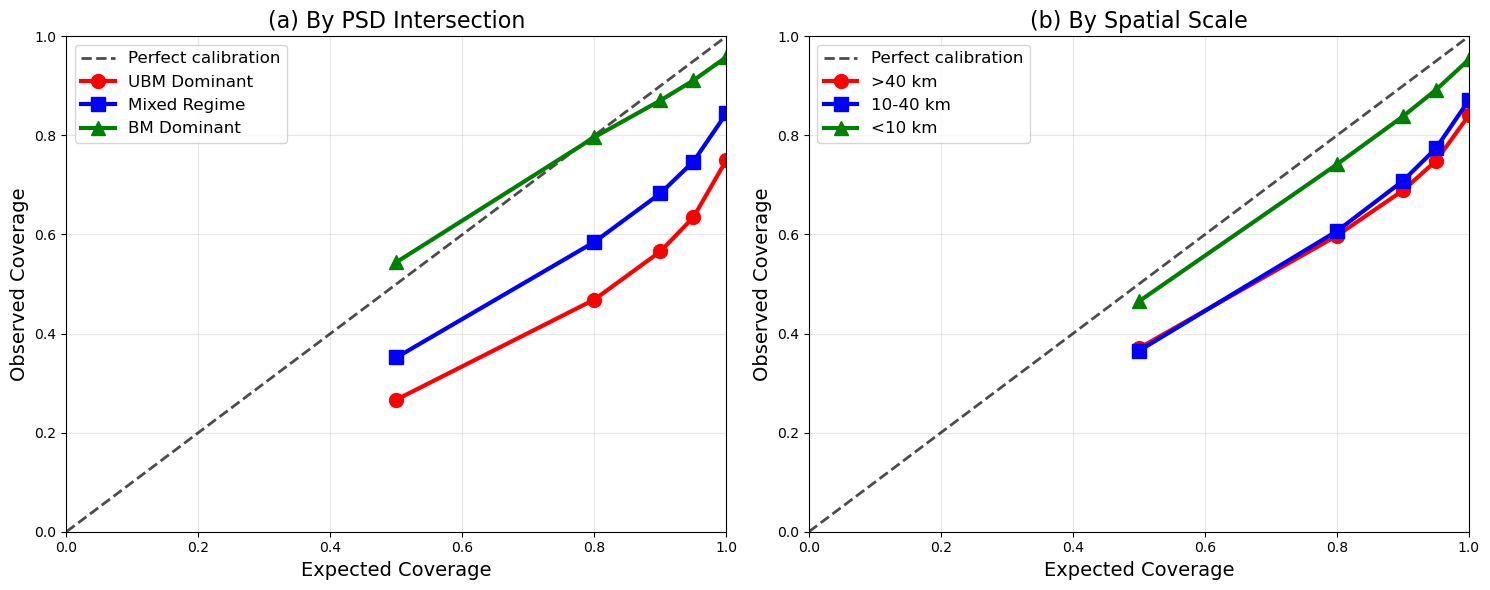


Two-panel calibration plot saved!


In [18]:
# ============================================================================
# VISUALIZATION: TWO-PANEL COMPARISON
# ============================================================================


# ============================================================================
# CALIBRATION PLOTTING FUNCTIONS
# ============================================================================

def plot_single_calibration(calibration_results, label, color, marker='o'):
    """
    Plot calibration curve for a single result set.
    """
    coverage_res = calibration_results['coverage_results']
    
    # Extract expected vs observed coverage
    expected = [res['expected_coverage'] for res in coverage_res.values()]
    observed = [res['observed_coverage'] for res in coverage_res.values()]
    
    # Plot the calibration curve
    plt.plot(expected, observed, color=color, marker=marker, linewidth=3, 
             markersize=10, label=label, linestyle='-')
    
    return expected, observed


def plot_combined_calibration(calibration_results_list, labels, title="Combined Calibration"):
    """
    Plot calibration curves for multiple results on the same panel.
    """
    # Colors and markers for different bins
    colors = ['red', 'blue', 'green']
    markers = ['o', 's', '^']
    
    # Perfect calibration line
    plt.plot([0, 1], [0, 1], 'k--', alpha=0.7, linewidth=2, label='Perfect calibration')
    
    # Plot each calibration result
    all_errors = []
    all_pixels = []
    
    for i, (results, label) in enumerate(zip(calibration_results_list, labels)):
        color = colors[i % len(colors)]
        marker = markers[i % len(markers)]
        
        expected, observed = plot_single_calibration(results, label, color, marker)
        
        # Collect statistics
        mean_error = results['mean_calibration_error']
        n_pixels = results['total_pixels_analyzed']
        all_errors.append(mean_error)
        all_pixels.append(n_pixels)
    
    plt.xlabel('Expected Coverage', fontsize=14)
    plt.ylabel('Observed Coverage', fontsize=14) 
    plt.title(title, fontsize=16)
    plt.legend(fontsize=12)
    plt.grid(True, alpha=0.3)
    plt.xlim(0, 1)
    plt.ylim(0, 1)


fig, (ax1, ax2) = plt.subplots(1, 2, figsize=(15, 6))

# Panel 1: PSD Intersection-based bins
plt.sca(ax1)
plot_combined_calibration(
    [bin0_bm, bin1_bm, bin2_bm], 
    ['UBM Dominant', 'Mixed Regime', 'BM Dominant'], 
    title="(a) By PSD Intersection"
)

# Panel 2: Scale-based filtering
plt.sca(ax2)
plot_combined_calibration(
    scale_calibrations,
    [config['label'] for config in scale_configs],
    title="(b) By Spatial Scale"
)

plt.tight_layout()

# Save figure
plt.savefig('figures/calibration_two_panel.png', 
            bbox_inches='tight', dpi=300, facecolor='white', 
            edgecolor='none', format='png')

plt.show()

print("\nTwo-panel calibration plot saved!")

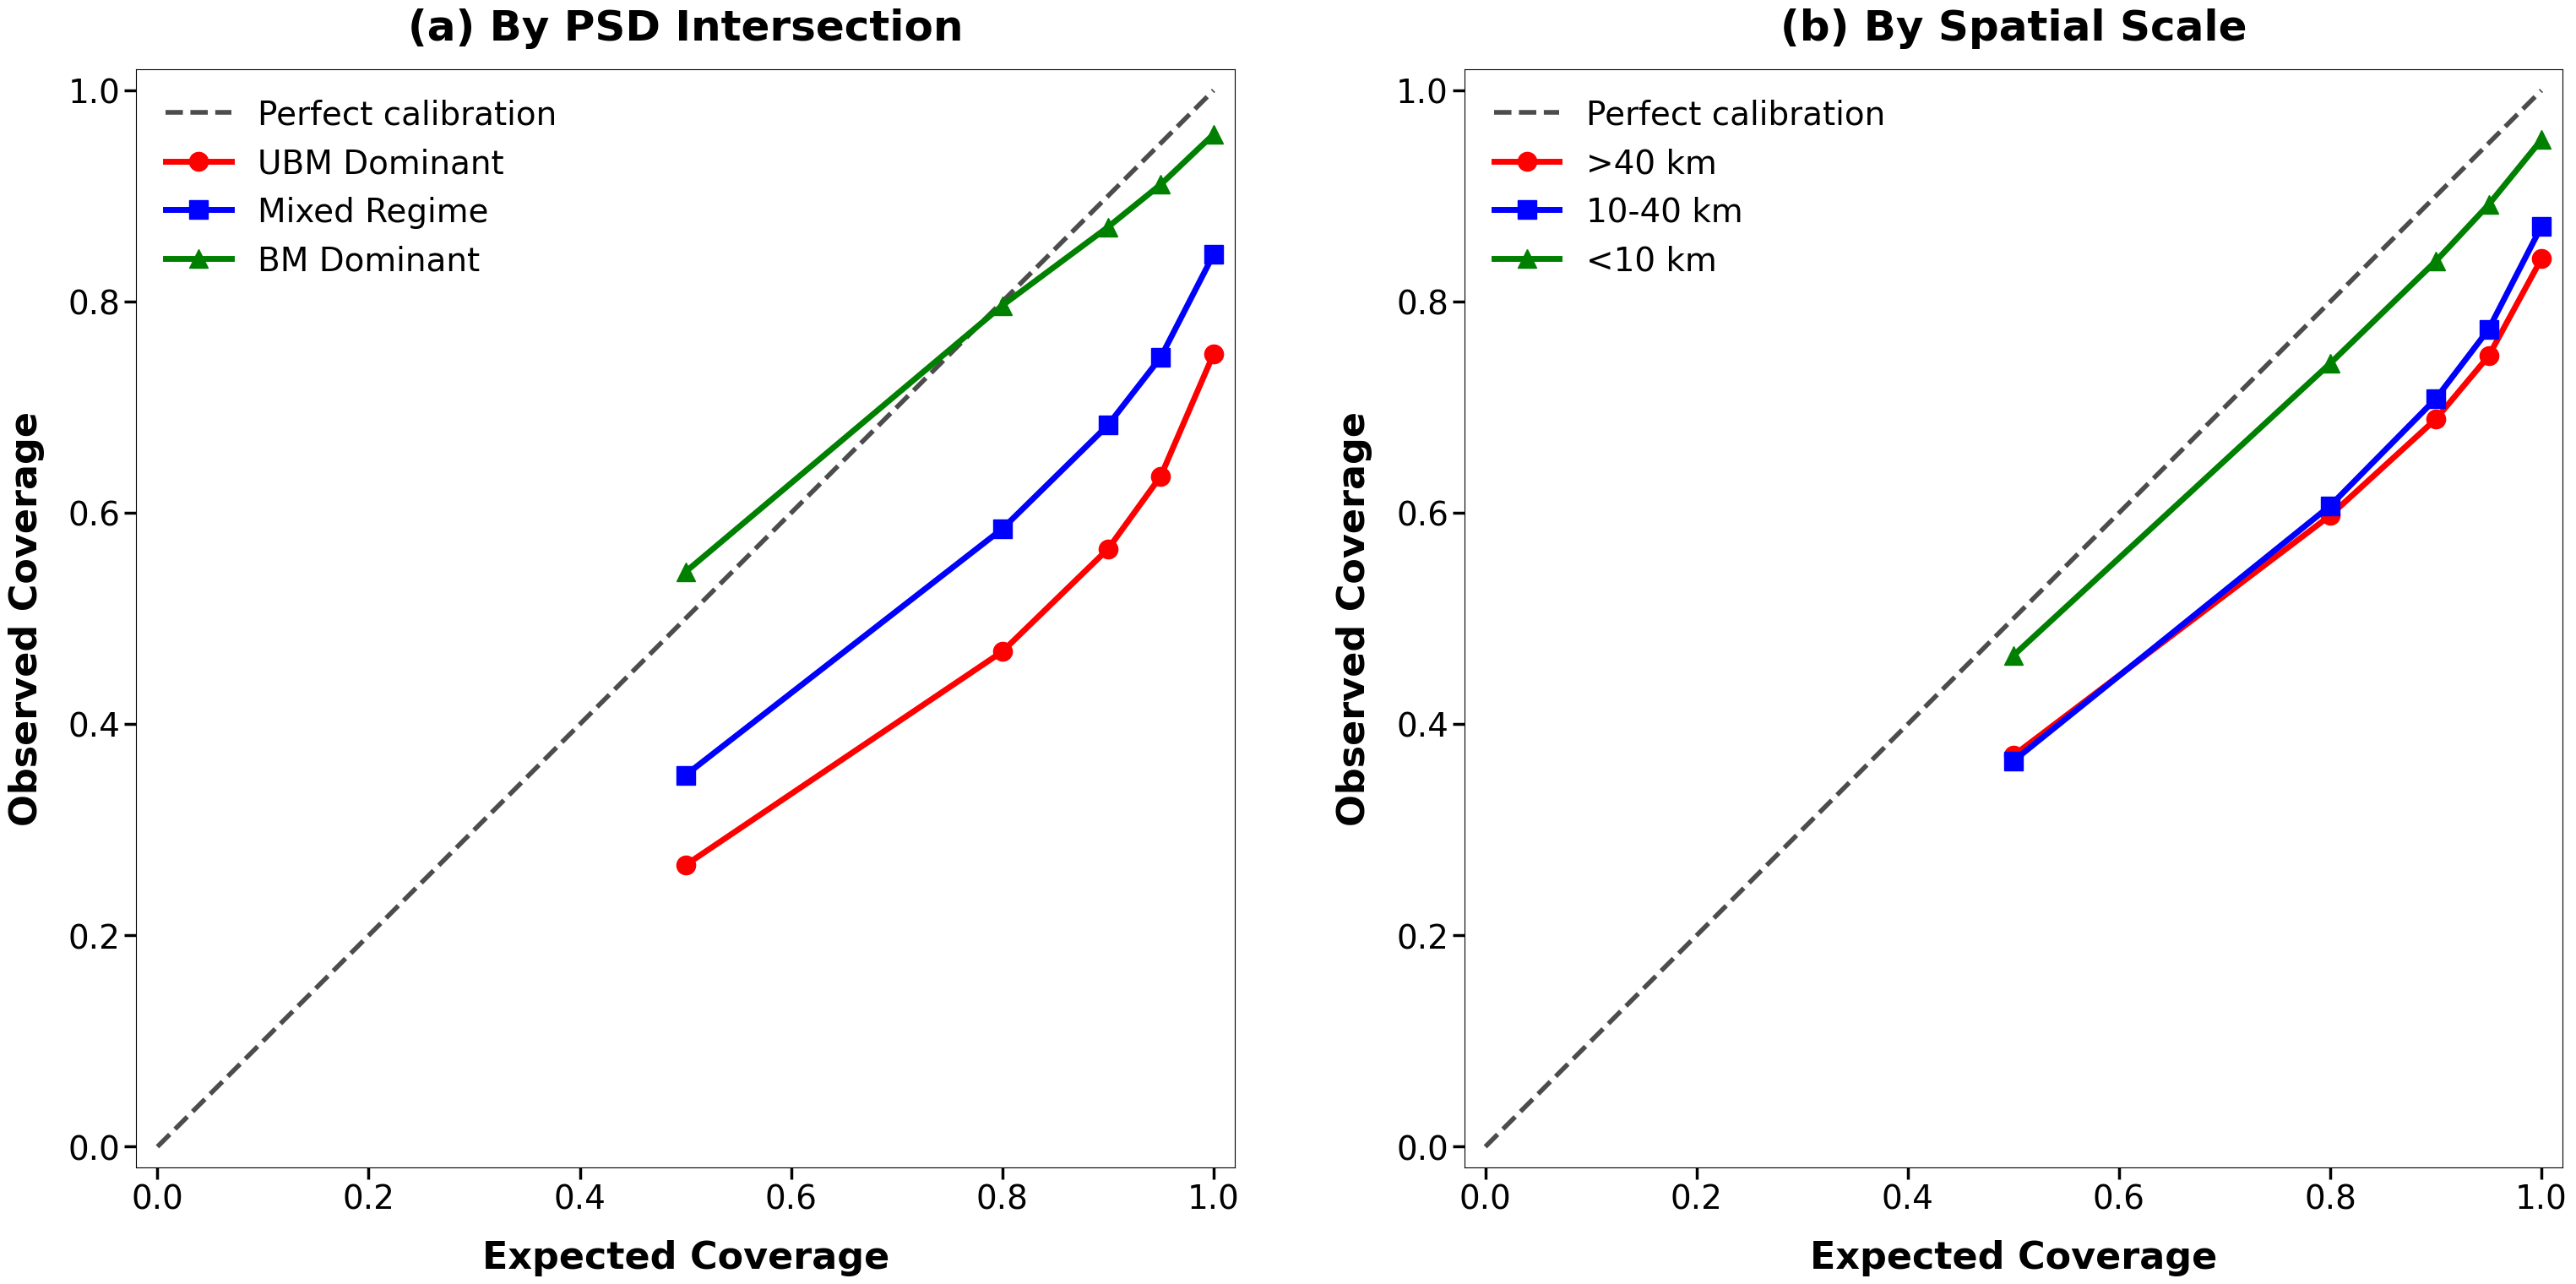


Two-panel calibration plot saved!


In [22]:
# ============================================================================
# VISUALIZATION: TWO-PANEL COMPARISON
# ============================================================================
# ============================================================================
# CALIBRATION PLOTTING FUNCTIONS
# ============================================================================
def plot_single_calibration(calibration_results, label, color, marker='o'):
    """
    Plot calibration curve for a single result set.
    """
    coverage_res = calibration_results['coverage_results']
    
    # Extract expected vs observed coverage
    expected = [res['expected_coverage'] for res in coverage_res.values()]
    observed = [res['observed_coverage'] for res in coverage_res.values()]
    
    # Plot the calibration curve
    plt.plot(expected, observed, color=color, marker=marker, linewidth=5, 
             markersize=16, label=label, linestyle='-')
    
    return expected, observed

def plot_combined_calibration(calibration_results_list, labels, title="Combined Calibration"):
    """
    Plot calibration curves for multiple results on the same panel.
    """
    # Colors and markers for different bins
    colors = ['red', 'blue', 'green']
    markers = ['o', 's', '^']
    
    # Perfect calibration line
    plt.plot([0, 1], [0, 1], 'k--', alpha=0.7, linewidth=4, label='Perfect calibration')
    
    # Plot each calibration result
    all_errors = []
    all_pixels = []
    
    for i, (results, label) in enumerate(zip(calibration_results_list, labels)):
        color = colors[i % len(colors)]
        marker = markers[i % len(markers)]
        
        expected, observed = plot_single_calibration(results, label, color, marker)
        
        # Collect statistics
        mean_error = results['mean_calibration_error']
        n_pixels = results['total_pixels_analyzed']
        all_errors.append(mean_error)
        all_pixels.append(n_pixels)
    
    plt.xlabel('Expected Coverage', fontsize=32, fontweight='bold', labelpad=20)
    plt.ylabel('Observed Coverage', fontsize=32, fontweight='bold', labelpad=20) 
    plt.title(title, fontsize=36, fontweight='bold', pad=25)
    plt.legend(fontsize=28, frameon=False)  # Removed frame
    # plt.grid(True, alpha=0.3)  # Removed grid
    plt.xlim(-0.02, 1.02)  # Better scale with small padding
    plt.ylim(-0.02, 1.02)  # Better scale with small padding
    plt.gca().set_aspect('equal', adjustable='box')  # Equal aspect ratio for better scale
    plt.tick_params(labelsize=28, width=2.5, length=10)  # Increased tick label size and tick size

fig, (ax1, ax2) = plt.subplots(1, 2, figsize=(32, 20))

# Panel 1: PSD Intersection-based bins
plt.sca(ax1)
plot_combined_calibration(
    [bin0_bm, bin1_bm, bin2_bm], 
    ['UBM Dominant', 'Mixed Regime', 'BM Dominant'], 
    title="(a) By PSD Intersection"
)

# Panel 2: Scale-based filtering
plt.sca(ax2)
plot_combined_calibration(
    scale_calibrations,
    [config['label'] for config in scale_configs],
    title="(b) By Spatial Scale"
)

plt.tight_layout(pad=6.0, w_pad=8.0)  # Increased padding between panels and edges

# Save figure
plt.savefig('figures/publication_figure6.png', 
            bbox_inches='tight', dpi=300, facecolor='white', 
            edgecolor='none', format='png')
plt.show()
print("\nTwo-panel calibration plot saved!")